**THIS NOTEBOOK CONTAINS FORECAST OF TRANSACTION AMOUNT FOR SELLER 16 FROM INVOICE DATA WITH TRAIN TEST APPROACH TO FIND THE BEST MODEL BY COMPARING AIC VALUES.**

In [239]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Below is the importing of data file. It also includes changing the format of date time and extracting the date from it.**

In [240]:
invoice=pd.read_csv("inv_transdt_transamt_selrid.csv")

**No null values are there in the code.**

In [241]:
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86319 entries, 0 to 86318
Data columns (total 3 columns):
TransactionDate    86319 non-null object
SellerId           86319 non-null int64
Trans_amount       86319 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


**Formating the datetime format.**

In [242]:
invoice["TransactionDate"]=pd.to_datetime(pd.to_datetime(invoice["TransactionDate"]).dt.date)

In [243]:
invoice.head()

,TransactionDate,SellerId,Trans_amount
0,2019-03-15,19,10000
1,2017-04-18,19,5000000
2,2019-07-18,1,5000
3,2019-07-18,1,13000
4,2019-07-18,1,17500


In [244]:
seller_count=invoice.groupby("SellerId").count()

**FORECAST FOR SELLER_21**

**Following is the time series preparation for seller 16 by extracting transaction date and Transaction amount.**

In [245]:
sel=invoice[invoice.SellerId==21][["TransactionDate","Trans_amount"]]
sel=sel.set_index("TransactionDate")
sel = sel.groupby(pd.Grouper(freq="M")).sum()
sel["Trans_amount"]=sel.Trans_amount.apply(lambda x:x)
ts=sel["Trans_amount"]

In [246]:
len(ts)

51

**Sample of the series.**

In [247]:
ts.tail(10)

TransactionDate
2019-06-30    54415527
2019-07-31    34245980
2019-08-31    37793980
2019-09-30     2180000
2019-10-31           0
2019-11-30     1391000
2019-12-31           0
2020-01-31      690000
2020-02-29           0
2020-03-31      690000
Freq: M, Name: Trans_amount, dtype: int64

In [248]:
ts.tail()

TransactionDate
2019-11-30    1391000
2019-12-31          0
2020-01-31     690000
2020-02-29          0
2020-03-31     690000
Freq: M, Name: Trans_amount, dtype: int64

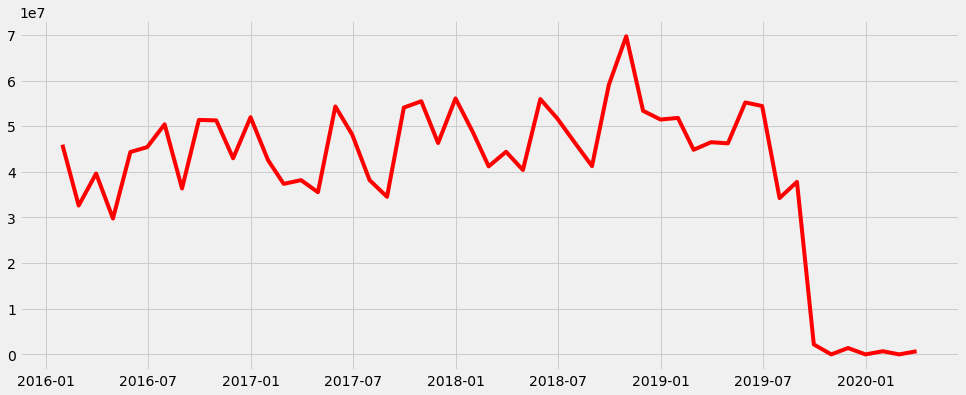

In [249]:
plt.figure(figsize=(15,6))
plt.plot(ts, color="red")

**This is dickey fuller test.**

In [250]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

In [251]:
dft(ts)

Test_stats                     -1.544760
p-value                         0.511264
#Lags Used                      0.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64

In [252]:
ts_log=np.log(ts[ts>0])

**This is the sample 10 datapoints.**

In [253]:
dft(ts_log)

Test_stats                      0.816513
p-value                         0.991898
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64

In [254]:
ts_log_diff=ts_log-ts_log.shift()

In [255]:
ts_log_diff=ts_log_diff.dropna()

In [256]:
ts_log_diff.tail()

TransactionDate
2019-08-31    0.098581
2019-09-30   -2.852825
2019-11-30   -0.449302
2020-01-31   -0.701087
2020-03-31    0.000000
Name: Trans_amount, dtype: float64

**Below is the test for stationarity of the time series.**

In [257]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

**Testing the stationariy for the series by using Dickey Fuller test.**

In [258]:
dft(ts_log_diff)

Test_stats                     -3.406326
p-value                         0.010745
#Lags Used                      1.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64

**Clearly the Test_stats is already lesser than the minimum critical values. So with 99% confidence it can be inferred that the series is stationary.**

**Below is the preparation of input parameters for the ARIMA model to be applied on the series.**

In [259]:
from statsmodels.tsa.stattools import acf, pacf
# Requisite libraries for computing auto correlation function and partial auto correlation function. 

In [260]:
lag_acf = acf(ts_log_diff, nlags=5)
lag_pacf = pacf(ts_log_diff, nlags=5, method='ols')
#ols stands for ordinary least squared.

Text(0.5, 1.0, 'Autocorrelation Function')

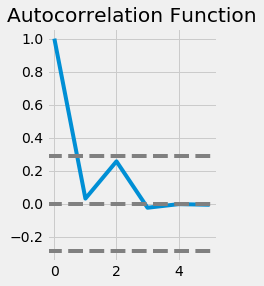

In [261]:
#This is the plotting of acf.
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
            

**From above plot it can be seen that plot is interesecting the upper confidence intervel at lag=4. so value of q is 4.**

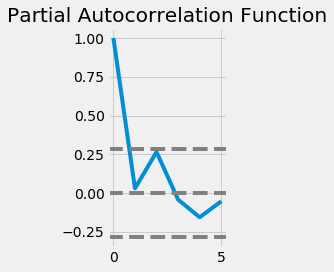

In [262]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**From above plot it can be seen that plot is interesecting the upper confidence intervel at lag=2. so value of p is 2.**

<font color="blue">**Applying train test approach to the data for seller 16**</font>

**Initially 90 % of data is taken in the training data set and remaining 10% in the testing data set.**

In [263]:
train_size = int(np.ceil(len(ts_log_diff)*0.9))

In [264]:
#Below is size of training data.
train_size

43

**The data is being split into training and testing set.**

In [265]:
train, test = ts_log_diff[0:train_size], ts_log_diff[train_size:len(ts_log_diff)]

In [266]:
train.tail()

TransactionDate
2019-04-30   -0.005376
2019-05-31    0.177122
2019-06-30   -0.014237
2019-07-31   -0.463080
2019-08-31    0.098581
Name: Trans_amount, dtype: float64

In [267]:
test.head()

TransactionDate
2019-09-30   -2.852825
2019-11-30   -0.449302
2020-01-31   -0.701087
2020-03-31    0.000000
Name: Trans_amount, dtype: float64

**Now testing the stationarity of the series.**

In [268]:
dft(train)

Test_stats                    -6.885576e+00
p-value                        1.397432e-09
#Lags Used                     1.000000e+01
Number of Observations Used    3.200000e+01
Critical Value (1%)           -3.653520e+00
Critical Value (5%)           -2.957219e+00
Critical Value (10%)          -2.617588e+00
dtype: float64

**Clearly the test_stats is lesser than even 1% critical value. So the series is stationary.**

In [269]:
#Importing the requisite libraries for arima model.
from statsmodels.tsa.arima_model import ARIMA

**Training the model with calculated values of p,q and d.**

In [270]:
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()

**Final prediction on test set of data by model.**

In [271]:
train.index

DatetimeIndex(['2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
               '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
               '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
               '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
               '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31', '2019-08-31'],
              dtype='datetime64[ns]', name='TransactionDate', freq=None)

In [272]:
test.index

DatetimeIndex(['2019-09-30', '2019-11-30', '2020-01-31', '2020-03-31'], dtype='datetime64[ns]', name='TransactionDate', freq=None)

In [273]:
predicted= model_fit.predict(test.index[0], test.index[-1])

In [274]:
def pred_fin(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:x)
    return prediction_final

In [275]:
final_prediction=pred_fin(predicted, train)

In [276]:
final_prediction

2019-08-31    0.098581
2019-09-30   -0.152947
2019-10-31    0.038886
2019-11-30   -0.003700
2019-12-31   -0.010607
2020-01-31    0.012710
2020-02-29   -0.016046
2020-03-31    0.014510
Freq: M, dtype: float64

In [277]:
final_prediction=final_prediction.cumsum()

In [278]:
final_forecast=np.exp(final_prediction)

In [279]:
final_forecast

2019-08-31    1.103603
2019-09-30    0.947085
2019-10-31    0.984639
2019-11-30    0.981002
2019-12-31    0.970652
2020-01-31    0.983068
2020-02-29    0.967420
2020-03-31    0.981559
Freq: M, dtype: float64

**test_prediction is the data frame containing the test data and the predicted output by the model.**

<font color="blue">**Akaike information criterion(AIC)**</font>  
**Akaike information criterion is the a model evaluation measure which considers mean sum squared of residuals and the number of parameters to evaluate the quality of a model. So lower the value of aic better is the model.**

In [280]:
model_fit.aic

2.4784352695494647

In [281]:
model_fit.bic

12.904452979249676

*For this model aic value is 1437.*

**Below is the forecast of payment amount for seller 16 with 90 percent data in the train set. In the figure below blue line is the training data, red is the forecasted one and green one is the test set value.**

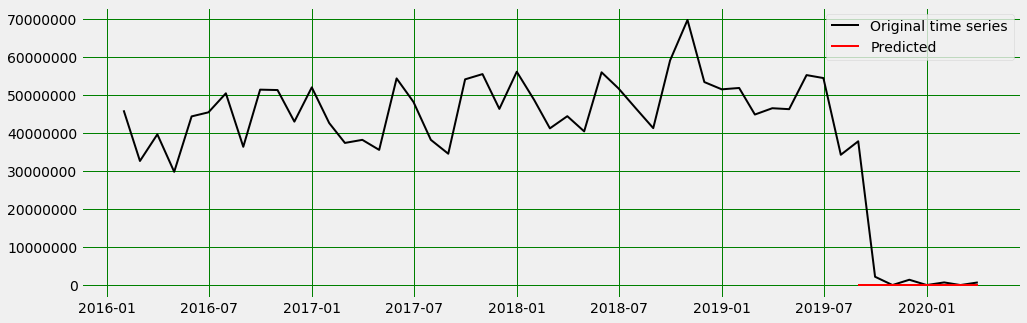

In [282]:
plt.figure(figsize=(15,5))
plt.plot(ts, color="black", linewidth=2, label="Original time series")
plt.plot(final_prediction,color="red", linewidth=2, label="Predicted")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="green")
plt.legend(loc="best")
plt.show()

**It is possible that at a different train test ratio we can have a lower value of Akaike Information Constant(aic) i.e. a better model.  
So in the below code an aic is explorated against the train test ratio.**

In [283]:
from statsmodels.tsa.arima_model import ARIMA
#An empty list to store mean squared error.
rmse=[]
#An empty list to store aic.
aic=[]
# An empty list storing fraction of total data present in training set.
ratio=[]
for x in np.arange(0.6,0.95,0.005):
    #size of training set.
    ts_log_diff=ts_log-ts_log.shift()
    ts_log_diff=ts_log_diff.dropna()
    train_size = int(len(ts_log_diff)*x)
    #splitting the data.    
    train, test = ts_log_diff[0:train_size], ts_log_diff[train_size:len(ts_log)]
    if dft(train)[0]<dft(train)[4]:
        model = ARIMA(train, order=(2,1,0))
        model_fit = model.fit()
        prediction_final= model_fit.predict(test.index[0], test.index[-1])
        predict=pred_fin(prediction_final, train)
        forecumsum=predict.cumsum()
        forecast=np.exp(forecumsum)
        aic.append(model_fit.aic)
        rmse.append(np.sqrt(np.mean((-test+forecast)**2)))
        ratio.append(x)     

ValueError: Length of passed values is 6, index implies 5

**In above code the if criteria compares the test_stats and the 1% critical value. If it is satisfying the criteria then only further evaluation is done. The corresponding aic values for different models have been stored in aic list.**

<font color="blue">**we will use to criterion to compare the models.**</font>  
**1. ROOT MEAN SQUARED ERROR(rmse)**  
**2. AKAIKI INFORMATION CONSTANT(aic).**

In [ ]:
aic_ratio=pd.DataFrame()
aic_ratio["aic"]=aic
aic_ratio["ratio"]=ratio

**Above dataframe contains different aic values corresponding to the fraction of total data in the training set.**

In [ ]:
aic_ratio

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(ratio,aic, color="red")
#plt.plot(ratio,rmse,color="red")
plt.xlabel("Ratio of train data")
plt.ylabel("Root Mean squared error on test data.")
plt.title("Error analysis with train test ratio", color="red")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="black")
plt.show() 

<font color="red">**In the above model the value of train size is passed in between 0.6 to 0.95. But in the plot we have only data from 0.775 to 0.950. The reason behind this is from 0.6 to 0.775 all the data have failed the stationarity test by Dicky Fuller test and hence they are automatically rejected.**</font>

**From above plot we can see that as the fraction is increasing aic value is also increasing. So at fraction = 0.815 aic is minimum.**

<font color="blue"> **NOW BELOW CODE IS PERFORMING THE BEST MODEL WITH TRAINING RATION 0.815**

In [ ]:
train_size = int(np.ceil(len(ts)*0.65))

In [284]:
train, test=ts[0:train_size], ts[train_size:]

In [285]:
dft(train)

Test_stats                     -4.199810
p-value                         0.000659
#Lags Used                      1.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64

In [286]:
from statsmodels.tsa.arima_model import ARIMA

**Below is preparing the final arima model.**

In [287]:
model = ARIMA(train, order=(1,0,2))
model_fit = model.fit()

In [288]:
train.tail()

TransactionDate
2019-04-30    46236257
2019-05-31    55195791
2019-06-30    54415527
2019-07-31    34245980
2019-08-31    37793980
Freq: M, Name: Trans_amount, dtype: int64

In [289]:
test.head()

TransactionDate
2019-09-30    2180000
2019-10-31          0
2019-11-30    1391000
2019-12-31          0
2020-01-31     690000
Freq: M, Name: Trans_amount, dtype: int64

**Prediction is done for test set as well as for coming 6 months.**

In [290]:
ts.tail()

TransactionDate
2019-11-30    1391000
2019-12-31          0
2020-01-31     690000
2020-02-29          0
2020-03-31     690000
Freq: M, Name: Trans_amount, dtype: int64

In [312]:
predicted= model_fit.predict("2019-09-30", "2020-03-31")

In [313]:
train.tail()

TransactionDate
2019-04-30    46236257
2019-05-31    55195791
2019-06-30    54415527
2019-07-31    34245980
2019-08-31    37793980
Freq: M, Name: Trans_amount, dtype: int64

In [314]:
test.head()

TransactionDate
2019-09-30    2180000
2019-10-31          0
2019-11-30    1391000
2019-12-31          0
2020-01-31     690000
Freq: M, Name: Trans_amount, dtype: int64

In [315]:
predicted

2019-09-30    4.471206e+07
2019-10-31    4.589947e+07
2019-11-30    4.591378e+07
2019-12-31    4.592758e+07
2020-01-31    4.594090e+07
2020-02-29    4.595374e+07
2020-03-31    4.596612e+07
Freq: M, dtype: float64

In [316]:
prediction_final=pred_fin(predicted, train)

In [317]:
prediction_final

2019-08-31    3.779398e+07
2019-09-30    4.471206e+07
2019-10-31    4.589947e+07
2019-11-30    4.591378e+07
2019-12-31    4.592758e+07
2020-01-31    4.594090e+07
2020-02-29    4.595374e+07
2020-03-31    4.596612e+07
Freq: M, dtype: float64

In [318]:
train.tail()

TransactionDate
2019-04-30    46236257
2019-05-31    55195791
2019-06-30    54415527
2019-07-31    34245980
2019-08-31    37793980
Freq: M, Name: Trans_amount, dtype: int64

In [319]:
model_fit.aic

1530.0399116606493

In [320]:
model_fit.bic

1538.9608598302407

**Above is the aic value for the model. which is least of all the possible models.**

In [321]:
len(ts)

51

In [322]:
prediction_final

2019-08-31    3.779398e+07
2019-09-30    4.471206e+07
2019-10-31    4.589947e+07
2019-11-30    4.591378e+07
2019-12-31    4.592758e+07
2020-01-31    4.594090e+07
2020-02-29    4.595374e+07
2020-03-31    4.596612e+07
Freq: M, dtype: float64

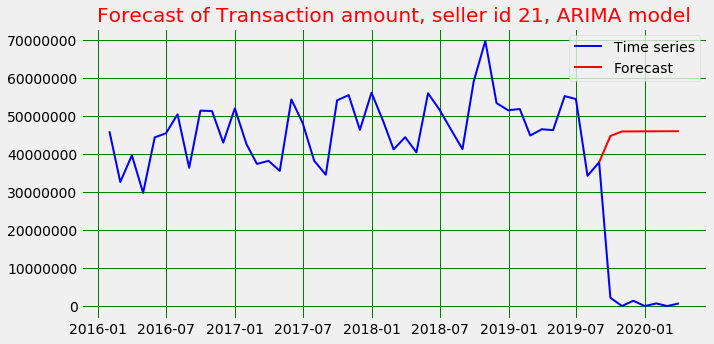

In [325]:
plt.figure(figsize=(10,5))
plt.plot(ts, color="blue", linewidth=2, label="Time series")
plt.plot(prediction_final,color="red", linewidth=2, label="Forecast")
plt.title("Forecast of Transaction amount, seller id 21, ARIMA model", color="red")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="green")
plt.legend(loc="best")
plt.show()